In [1]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.7 MB 4.7 MB/s 


In [2]:
# https://www.bindingdb.org/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_All_2022m3.tsv.zip
!wget https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m3.tsv.zip

--2022-05-05 08:49:57--  https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m3.tsv.zip
Resolving www.bindingdb.org (www.bindingdb.org)... 137.110.139.247
Connecting to www.bindingdb.org (www.bindingdb.org)|137.110.139.247|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 417326199 (398M) [application/zip]
Saving to: ‘BindingDB_All_2022m3.tsv.zip’

BindingDB_All_2022m 100%[===================>] 397.99M  8.63MB/s    in 47s     

2022-05-05 08:50:44 (8.52 MB/s) - ‘BindingDB_All_2022m3.tsv.zip’ saved [417326199/417326199]



In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm.auto import tqdm


tqdm.pandas()

In [4]:
data = pd.read_csv("BindingDB_All_2022m3.tsv.zip", compression='zip', sep = '\t', nrows = 100)

In [5]:
COLS = ['Ligand SMILES',
        'Target Source Organism According to Curator or DataSource',
        'Ki (nM)',
        'IC50 (nM)',
        'Kd (nM)',
        'EC50 (nM)',
        'pH',
#        'kon (M-1-s-1)',
#        'koff (s-1)',
#        'Temp (C)',
#        'Number of Protein Chains in Target (>1 implies a multichain complex)',
        'BindingDB Target Chain  Sequence']


NAMES = {'Ligand SMILES' : 'smiles',
         'Target Source Organism According to Curator or DataSource': 'target_name',
        'Ki (nM)' : 'Ki_nM',
        'IC50 (nM)': 'IC50_nM',
        'Kd (nM)': 'Kd_nM',
        'EC50 (nM)': 'EC50_nM',
         'kon (M-1-s-1)': 'kon',
         'koff (s-1)' : 'koff',
         'Temp (C)' : 'T',
         'Number of Protein Chains in Target (>1 implies a multichain complex)' : 'N',
        'BindingDB Target Chain  Sequence' : 'target'}

In [6]:
data = pd.read_csv("BindingDB_All_2022m3.tsv.zip", compression='zip', sep = '\t', usecols=COLS)
data.rename(columns=NAMES, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
data.notna().sum()

smiles         2407376
target_name    1614153
Ki_nM           529198
IC50_nM        1560959
Kd_nM            95555
EC50_nM         225382
pH              215293
target         2406806
dtype: int64

In [8]:
data.head(2)

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,5.5,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,5.5,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...


In [9]:
data.groupby('target_name')[['target']].nunique().sort_values(by='target', ascending=False).head(3)

,target
target_name,
Homo sapiens,1981
Rattus norvegicus,461
Mus musculus,450


In [10]:
data = data[data['target_name'].str.lower().str.strip().isin(['homo sapiens'])]
data.shape

(1274797, 8)

In [11]:
def to_non_isomeric_canonical(s):
    """
    Removes isomeric features and makes RDKit canonical.

    Example:
    pubchem_torin1 = "CCC(=O)N1CCN(CC1)C2=C(C=C(C=C2)N3C(=O)C=CC4=CN=C5C=CC(=CC5=C43)C6=CC7=CC=CC=C7N=C6)C(F)(F)F"
    to_non_isomeric_canonical(pubchem_torin1)
    >>CCC(=O)N1CCN(c2ccc(-n3c(=O)ccc4cnc5ccc(-c6cnc7ccccc7c6)cc5c43)cc2C(F)(F)F)CC1
    """
    try:
        mol = Chem.MolFromSmiles(s)
        s = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        return s
    except Exception as e:
        # if smiles is invalid return NaN
        return np.nan

In [12]:
def certain_to_float(S):
    S = str(S)
    S = S.replace("+", '').replace("-",'')
    S = S.replace(">", "").replace('<', '')
    S = S.replace("E", 'e')
    S = S.replace("C", '')

    try:
        F = float(S.strip())
        return F
    except Exception as e:
        print(e)
        return np.nan

In [13]:
constants = ['Ki_nM', 'IC50_nM','Kd_nM', 'EC50_nM', 'pH']
for col in constants:
    data[col] = data[col].astype('str')
    data[col] = data[col].progress_apply(certain_to_float)

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

  0%|          | 0/1274797 [00:00<?, ?it/s]

In [14]:
data.shape # 1274797

(1274797, 8)

In [15]:
data = data[data[constants].notna().max(axis=1)]
data.shape # 1273849

(1273849, 8)

In [16]:
data.corr()

,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH
Ki_nM,1.000000,0.480270,0.931902,0.668483,0.039315
IC50_nM,0.480270,1.000000,0.479908,0.679801,-0.000390
Kd_nM,0.931902,0.479908,1.000000,0.970497,0.011839
EC50_nM,0.668483,0.679801,0.970497,1.000000,-0.001667
pH,0.039315,-0.000390,0.011839,-0.001667,1.000000


In [17]:
data['smiles'] = data['smiles'].progress_apply(to_non_isomeric_canonical)

  0%|          | 0/1273849 [00:00<?, ?it/s]

In [18]:
data = data[data['smiles'] .notna()]
data.shape

(1272888, 8)

In [19]:
data.head(2)

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target
142,Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...,Homo sapiens,NaN,50000.0,NaN,NaN,NaN,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...
198,CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)NC(CC(=O)O...,Homo sapiens,90.0,NaN,NaN,NaN,7.4,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...


In [20]:
def is_active(Ki_nM, IC50_nM, Kd_nM, EC50_nM):
    for x in [Ki_nM, IC50_nM, Kd_nM, EC50_nM]:
        if (x / 1000) < 1:
            return 1    
    return 0

In [21]:
data["is_active"] = data.progress_apply(lambda x: is_active(x.Ki_nM, x.IC50_nM, x.Kd_nM, x.EC50_nM), axis=1)

  0%|          | 0/1272888 [00:00<?, ?it/s]

In [ ]:
def to_tdc_log(y):
    y = -np.log10(y*1e-9 + 1e-10)
    if y<0:
        return np.nan
    return y

In [ ]:
def from_tdc_log(y):
    y = (10**(-y)- 1e-10)/1e-9
    return y

In [23]:
def to_mltle_log(y):
    return np.log1p(y)

In [24]:
constants = ['Ki_nM', 'IC50_nM','Kd_nM', 'EC50_nM']
for col in constants:
    data['p1' + col.split('_')[0]] = data[col].apply(to_mltle_log)

In [25]:
data.corr()

,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,is_active,p1Ki,p1IC50,p1Kd,p1EC50
Ki_nM,1.000000,0.480270,0.931902,0.668483,0.039393,-0.046833,0.238396,0.136931,0.734668,0.339387
IC50_nM,0.480270,1.000000,0.479908,0.679801,-0.000371,-0.003555,0.119111,0.022363,0.339045,0.245660
Kd_nM,0.931902,0.479908,1.000000,0.970497,0.011839,-0.016293,0.631893,0.429084,0.080584,0.849249
EC50_nM,0.668483,0.679801,0.970497,1.000000,-0.001697,-0.006188,0.241393,0.232767,0.767761,0.042321
pH,0.039393,-0.000371,0.011839,-0.001697,1.000000,0.110201,-0.028699,-0.161683,-0.143633,-0.041305
is_active,-0.046833,-0.003555,-0.016293,-0.006188,0.110201,1.000000,-0.781172,-0.836861,-0.860000,-0.838766
p1Ki,0.238396,0.119111,0.631893,0.241393,-0.028699,-0.781172,1.000000,0.780093,0.982709,0.596956
p1IC50,0.136931,0.022363,0.429084,0.232767,-0.161683,-0.836861,0.780093,1.000000,0.930419,0.623628
p1Kd,0.734668,0.339045,0.080584,0.767761,-0.143633,-0.860000,0.982709,0.930419,1.000000,0.834716
p1EC50,0.339387,0.245660,0.849249,0.042321,-0.041305,-0.838766,0.596956,0.623628,0.834716,1.000000


In [26]:
constants = ['p1Ki', 'p1IC50','p1Kd', 'p1EC50', 'is_active', 'pH']

In [27]:
data['smiles'] = data['smiles'].str.strip()
data['target'] = data['target'].str.strip().str.upper()
data.head(2)

,smiles,target_name,Ki_nM,IC50_nM,Kd_nM,EC50_nM,pH,target,is_active,p1Ki,p1IC50,p1Kd,p1EC50
142,Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...,Homo sapiens,NaN,50000.0,NaN,NaN,NaN,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,0,NaN,10.819798,NaN,NaN
198,CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)NC(CC(=O)O...,Homo sapiens,90.0,NaN,NaN,NaN,7.4,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...,1,4.51086,NaN,NaN,NaN


In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
# K = []
# for i in tqdm(range(1, 100, 2)):
#     d = data.groupby(['smiles', 'target'], as_index=False, sort=False).quantile(i/100)
#     d = d[d[constants].notna().max(axis=1)]
#     s = d[constants].corr().abs().values.ravel().sum()
#     K.append(s)

# q = (np.argmax(K) + 1)/100
# print(q)

In [30]:
data1 = data.copy()
data = data.groupby(['smiles', 'target'], as_index=False, sort=False).quantile(0.5)
data.shape

(908207, 12)

In [31]:
data = data[data[constants].notna().max(axis=1)]
data.shape

(908207, 12)

In [32]:
data[constants].notna().sum()

p1Ki         214052
p1IC50       610502
p1Kd          39379
p1EC50        84487
is_active    908207
pH            97668
dtype: int64

In [33]:
data[constants].corr()

,p1Ki,p1IC50,p1Kd,p1EC50,is_active,pH
p1Ki,1.000000,0.802805,0.702821,0.563183,-0.782916,-0.048628
p1IC50,0.802805,1.000000,0.777114,0.737645,-0.842390,-0.168278
p1Kd,0.702821,0.777114,1.000000,0.659220,-0.847780,-0.201695
p1EC50,0.563183,0.737645,0.659220,1.000000,-0.834182,0.054365
is_active,-0.782916,-0.842390,-0.847780,-0.834182,1.000000,0.114203
pH,-0.048628,-0.168278,-0.201695,0.054365,0.114203,1.000000


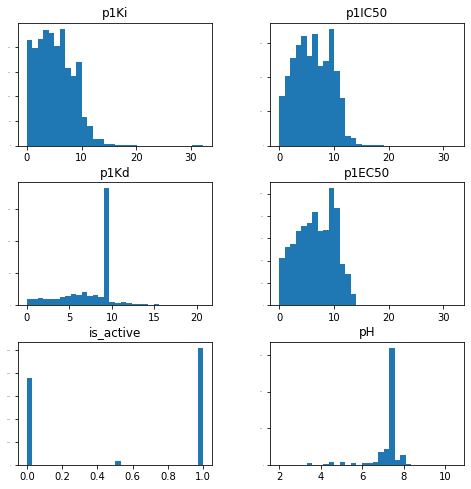

In [34]:
data[constants].hist(layout = (5, 2), grid = False, bins = 32, figsize = (8, 14), ylabelsize = 0);

In [35]:
data = data[['smiles', 'target'] + constants]

In [36]:
data['is_active'] = data['is_active'].round()

In [37]:
data['is_active'].value_counts(normalize=True)

1.0    0.562432
0.0    0.437568
Name: is_active, dtype: float64

In [38]:
data.target.str.startswith('M').mean()

0.9976756400247961

In [39]:
data = data[data.target.str.startswith('M')]
data['is_active'].value_counts(normalize=True)

1.0    0.562698
0.0    0.437302
Name: is_active, dtype: float64

In [41]:
data.tail()

,smiles,target,p1Ki,p1IC50,p1Kd,p1EC50,is_active,pH
908202,COc1cc(C2=CC3=NOCC(c4cc(F)c(F)c(F)c4)N3CCC2)cc...,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,NaN,10.308986,NaN,NaN,0.0,NaN
908203,COc1cc(C=C2CCCN3C2=NOC(c2cc(F)cc(F)c2)C3C)ccc1...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,10.404293,NaN,NaN,0.0,NaN
908204,COc1cc(C=C2CCCN3C2=NOC(c2cc(F)c(F)c(F)c2)C3C)c...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,10.518700,NaN,NaN,0.0,NaN
908205,COc1cc(C2=CC3=NOC(c4cc(F)c(F)c(F)c4)CN3CCC2)cc...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,9.798183,NaN,NaN,0.0,NaN
908206,COc1cc(C2=CC3=NOCC(c4cc(F)c(F)c(F)c4)N3CCC2)cc...,MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIG...,NaN,8.987322,NaN,NaN,0.0,NaN


In [42]:
data.to_csv("data_human_agg05_pH.zip", index=False, compression = 'zip')